## Udacity Project - Recommendations with IBM

#### Table of Contents
- I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
- II. [Rank Based Recommendations](#Rank)<br>
- III. [User-User Based Collaborative Filtering](#User-User)<br>
- IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
- V. [Matrix Factorization](#Matrix-Fact)<br>
- VI. [Extras & Concluding](#conclusions)

In [78]:
import pandas as pd
import numpy as np
import project_tests as t
import re
from IPython.display import display, Image

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger','stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

init_notebook_mode(connected = True)

pd.set_option('display.max_colwidth', 200)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lemsf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lemsf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lemsf\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lemsf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load the datasets

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')

del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [3]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show data layout

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [5]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VIDEO IS UNAVAILABLE.\r\nWATCH QUEUE\r\nQUEUE\r\nWatch Queue Queue * Remove all\r\n * Disconnect\r\n\r\nThe next ...",Detect bad readings in real time using Python and Streaming Analytics.,Detect Malfunctioning IoT Sensors with Streaming Analytics,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data science: A guide to presenting your work 4COMMUNICATING DATA SCIENCE: A GUIDE TO PRESENTING YOUR WORK\r\nMegan ...,"See the forest, see the trees. Here lies the challenge in both performing and presenting an analysis. As data scientists, analysts, and machine learning engineers faced with fulfilling business obj…",Communicating data science: A guide to presenting your work,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Paths\r\n * Courses * Our Courses\r\n * Partner Courses\r\n \r\n \r\n * Badges * Our Badges\r\n * BDU Badge Program\r\n \r\n \r\n * Watson ...,Here’s this week’s news in Data Science and Big Data.,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCALE - BOOST THE PERFORMANCE OF YOUR\r\nDISTRIBUTED DATABASE\r\nShare on Twitter Share on Facebook Share on Google+ Vote on Hacker News Published Dec 29...","Learn how distributed DBs solve the problem of scaling persistent storage, but introduce latency as data size increases and become I/O bound.",DataLayer Conference: Boost the performance of your distributed database,Live,3
4,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VIDEO IS UNAVAILABLE.\r\nWATCH QUEUE\r\nQUEUE\r\nWatch Queue Queue * Remove all\r\n * Disconnect\r\n\r\nThe next ...",This video demonstrates the power of IBM DataScience Experience using a simple New York State Restaurant Inspections data scenario.,Analyze NY Restaurant data using Spark in DSX,Live,4


In [6]:
#Show data layout
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>


`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [7]:

# How many viewers for each article ?

article_read = df.groupby('article_id').email.count().reset_index()
article_read.rename(columns={'email': 'readers'}, inplace=True)

print('Summary of viewers per article')
print('------------------------------------------------------')
display(article_read['readers'].describe())


Summary of viewers per article
------------------------------------------------------


count    714.000000
mean      64.392157
std      109.161462
min        1.000000
25%        8.000000
50%       25.000000
75%       69.000000
max      937.000000
Name: readers, dtype: float64

In [8]:
# How many articles a user reads ?

user_read = df.groupby('email').article_id.count().reset_index()
user_read.rename(columns={'article_id': 'articles'}, inplace=True)

print('Distribution of articles viewed per user')
print('------------------------------------------------------')
display(user_read['articles'].describe())

Distribution of articles viewed per user
------------------------------------------------------


count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: articles, dtype: float64

In [68]:

# Define the threshold for the trailing bin
threshold = 300 

# Adjust the data for the trailing bin

x1 = article_read['readers'].apply(lambda x: threshold if x >= threshold else x)

trace1 =go.Histogram(
    x=x1, 
    opacity=0.75,
    name='Views per Article',
    xbins=dict( # bins used for histogram
        start=0,
        end=threshold,
        size=5 ),
    marker= dict(color='red')
)


# Adjust the data for the trailing bin
x2 = user_read['articles'].apply(lambda x: threshold if x >= threshold else x)

trace2 =go.Histogram(
    x=x2,
    opacity=0.75,
    name='Articles per User',
    xbins=dict( # bins used for histogram
        start=0,
        end=threshold,
        size=5 ),
    marker= dict(color='darkblue')
)

fig = tools.make_subplots(rows=1, cols=2)
fig.append_trace(trace1, 1,1)
fig.append_trace(trace2, 1,2)
fig['layout'].update(
    height = 500, 
    width = 900, 
    title ='User x Article Interactions',
    titlefont = dict(size=13),
    margin=dict(l=50, r=30, t=40, b=50),    
    bargap=0.1,
    yaxis1 = {
        'title': 'Frequency',
        'titlefont': dict(size=12),
        'tickfont' : dict(size=10),
        'gridwidth': None
        },
    xaxis1 = {
        'title': 'No of Times an Article is Viewed', 
        'titlefont': dict(size=10)
        },        
    yaxis2 = {
        #'title': 'Frequency',
        'titlefont': dict(size=12),
        'tickfont' : dict(size=10),
        'gridwidth': None        
        },
    xaxis2 = {
        'title': 'No of Articles a User Views', 
        'titlefont': dict(size=10)
        },
    legend=dict(
        x=0.8,  # Horizontally center the legend
        y=0.8,  # Adjust vertical position as needed
        xanchor='center',  # Ensure that x=0.5 is the center of the legend
        yanchor='middle'   # Ensure that y=0.5 is the middle of the legend
    )              
    )

iplot(fig)


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



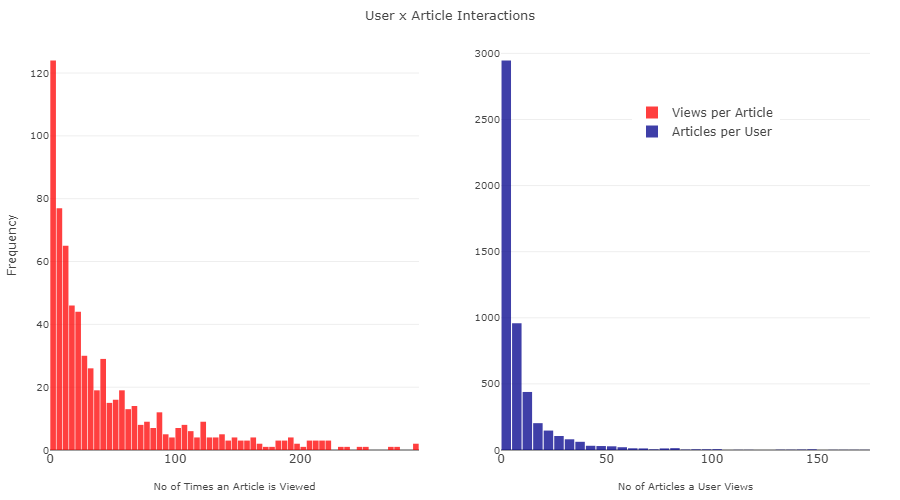

In [89]:

Image(filename="static/user_item_viz.png", width="750") 

In [10]:
# Fill in the median and maximum number of user_article interactios below

# 50% of individuals interact with ____ number of articles or fewer.
median_val = user_read['articles'].median()
print(f'50% of individuals interact with {median_val} number of articles or fewer')

# The maximum number of user-article interactions by any 1 user is _____
max_views_by_user =  user_read['articles'].max()
print(f'The maximum number of user-article interactions by any 1 user is {max_views_by_user}')

50% of individuals interact with 3.0 number of articles or fewer
The maximum number of user-article interactions by any 1 user is 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [11]:
# Find and explore duplicate articles

print('Duplicate records in df_content')
df_content.loc[df_content['article_id'].duplicated(keep=False)].sort_values(by=['article_id'])

Duplicate records in df_content


,doc_body,doc_description,doc_full_name,doc_status,article_id
50,"Follow Sign in / Sign up Home About Insight Data Science Data Engineering Health Data AI Never miss a story from Insight Data , when you sign up for Medium. Learn more Never miss a story from Insi...",Community Detection at Scale,Graph-based machine learning,Live,50
365,"Follow Sign in / Sign up Home About Insight Data Science Data Engineering Health Data AI 5 * Share\r\n * 5\r\n * \r\n * \r\n\r\nNever miss a story from Insight Data , when you sign up for Medium. ...",During the seven-week Insight Data Engineering Fellows Program recent grads and experienced software engineers learn the latest open source technologies by building a data platform to handle large…,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\nSearch within Bluemix Blog Bluemix Blog * About Bluemix * What is Bluemix\r\n * Getting Started\r\n * Case Studies\r\n * Hybrid Architecture\...,"When used to make sense of huge amounts of constantly changing data, smart catalog capabilities can make all the difference.",How smart catalogs can turn the big data flood into an ocean of opportunity,Live,221
692,Homepage Follow Sign in / Sign up Homepage * Home\r\n * Data Science Experience\r\n * Data Catalog\r\n * \r\n * Watson Data Platform\r\n * \r\n\r\nSusanna Tai Blocked Unblock Follow Following Offe...,"One of the earliest documented catalogs was compiled at the great library of Alexandria in the third century BC, to help scholars manage, understand and access its vast collection of literature…",How smart catalogs can turn the big data flood into an ocean of opportunity,Live,221
232,Homepage Follow Sign in Get started Homepage * Home\r\n * Data Science Experience\r\n * Data Catalog\r\n * IBM Data Refinery\r\n * \r\n * Watson Data Platform\r\n * \r\n\r\nCarmen Ruppach Blocked ...,"If you are like most data scientists, you are probably spending a lot of time to cleanse, shape and prepare your data before you can actually start with the more enjoyable part of building and…",Self-service data preparation with IBM Data Refinery,Live,232
971,Homepage Follow Sign in Get started * Home\r\n * Data Science Experience\r\n * Data Catalog\r\n * IBM Data Refinery\r\n * \r\n * Watson Data Platform\r\n * \r\n\r\nCarmen Ruppach Blocked Unblock F...,"If you are like most data scientists, you are probably spending a lot of time to cleanse, shape and prepare your data before you can actually start with the more enjoyable part of building and…",Self-service data preparation with IBM Data Refinery,Live,232
399,Homepage Follow Sign in Get started * Home\r\n * Data Science Experience\r\n * Data Catalog\r\n * IBM Data Refinery\r\n * \r\n * Watson Data Platform\r\n * \r\n\r\nSourav Mazumder Blocked Unblock ...,"Today’s world of data science leverages data from various sources. Commonly, these sources are Hadoop File System, Enterprise Data Warehouse, Relational Database systems, Enterprise file systems, ...",Using Apache Spark as a parallel processing framework for accessing REST based data services,Live,398
761,Homepage Follow Sign in Get started Homepage * Home\r\n * Data Science Experience\r\n * Data Catalog\r\n * IBM Data Refinery\r\n * \r\n * Watson Data Platform\r\n * \r\n\r\nSourav Mazumder Blocked...,"Today’s world of data science leverages data from various sources. Commonly, these sources are Hadoop File System, Enterprise Data Warehouse, Relational Database systems, Enterprise file systems, ...",Using Apache Spark as a parallel processing framework for accessing REST based data services,Live,398
578,This video shows you how to construct queries to access the primary index through the API.Visit http://www.cloudant.com/sign-up to sign up for a free Cloudant account. Find more videos and tutoria...,This video shows you how to construct queries to access the primary index through Cloudant's API.,Use the Primary Index,Live,577
970,This video shows you how to construct queries to access 

In [12]:
# Remove any rows that have the same article_id - only keep the first

print('Original Size:', df_content.shape)
df_content = df_content.drop_duplicates(subset='article_id', keep='first')
print('Size after deduped:', df_content.shape)

Original Size: (1056, 5)
Size after deduped: (1051, 5)


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [13]:

unique_articles = df['article_id'].nunique()
print('The number of unique articles that have at least one interaction:', unique_articles)

total_articles =  df_content['article_id'].nunique()
print('The number of unique articles listed on the community file:', total_articles)

unique_users = df['email'].nunique()
print('The number of unique users:', unique_users)

user_article_interactions =  df.shape[0] 
print('The number of user-article interactions:', user_article_interactions)

The number of unique articles that have at least one interaction: 714
The number of unique articles listed on the community file: 1051
The number of unique users: 5148
The number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [14]:

# index of article id with most read/viewed by users
max_index = article_read['readers'].idxmax()
print('Index of article with most views:', max_index)

Index of article with most views: 699


In [15]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(article_read.loc[max_index, 'article_id'])

# The most viewed article in the dataset was viewed how many times?
max_views = article_read.loc[max_index, 'readers']

print(f'Most viewed article {most_viewed_article_id}, Maximum view {max_views}')

Most viewed article 1429.0, Maximum view 937


In [16]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [17]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [18]:

def get_top_articles(n, df=df):
    
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''

    # Find top article_ids (this avoids grouping articles with identical titles)
    articles_cnt = list(df.groupby('article_id')['user_id'].count().sort_values(ascending=False).index)
    top_id = articles_cnt[:n]
    
    # Find titles of those articles
    top_articles = df.loc[df.article_id.isin(top_id),['article_id','title']].drop_duplicates()
    top_articles = list(top_articles.title)
        
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''

    # Find top article_ids (this avoids grouping articles with identical titles)
    articles_cnt = list(df.groupby('article_id')['user_id'].count().sort_values(ascending=False).index)
    top_articles_id = articles_cnt[:n]
 
    return list(map(str, top_articles_id)) # Return the top article ids


In [19]:

# Top Article IDs, Articles 
print('Popular Articles')
print('------------------------------------------------------')
for id, title in zip(get_top_article_ids(5), get_top_articles(5)):
    print(id, title.title())


Popular Articles
------------------------------------------------------
1429.0 Use Deep Learning For Image Classification
1330.0 Predicting Churn With The Spss Random Tree Algorithm
1431.0 Visualize Car Data With Brunel
1427.0 Use Xgboost, Scikit-Learn & Ibm Watson Machine Learning Apis
1364.0 Insights From New York Car Accident Reports


In [20]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [21]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    user_item = df.groupby(['user_id','article_id'])['user_id'].nunique().unstack()
    user_item.fillna(0, inplace=True)
    
    return user_item # return the user_item matrix 


In [22]:

user_item = create_user_item_matrix(df)
print('User Item matrix:', user_item.shape)


User Item matrix: (5149, 714)


In [23]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [24]:

def find_similar_users(user_id, user_item=user_item, return_similarity=False):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_similarity = np.dot(user_item.loc[user_id], user_item.T)

    # Sort similarities in descending order and get the corresponding user IDs
    # Exclude the similarity with itself 
    sorted_ids = np.argsort(user_similarity)[::-1]   
    most_similar_users = list(user_item.index[sorted_ids][1:])
    sorted_similarity = list(user_similarity[sorted_ids][1:])

    if return_similarity:
        # return a list of the users in order from most to least similar
        return most_similar_users, sorted_similarity 
    else:
        return most_similar_users
        

In [25]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [3933, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [46, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [26]:

def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names= list(df[df['article_id'].isin(article_ids)]['title'].unique())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    # Fetching article ids where the user interaction is 1 (has interacted)
    article_ids = user_item.loc[user_id, user_item.loc[user_id] == 1].index.tolist()
    article_names = get_article_names(article_ids)

    return list(map(str, article_ids)), article_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    ''' 

    similar_users = find_similar_users(user_id, user_item)
    articles_seen_ids = set(get_user_articles(user_id, user_item)[0])

    rec_ids = set()

    for user in similar_users:
        articles_rec_ids, _ = get_user_articles(user, user_item)
        new_recs = set(articles_rec_ids) - articles_seen_ids
        rec_ids.update(new_recs)

        if len(rec_ids) > m:
            break

    rec_names = get_article_names(list(rec_ids)[:m], df)

    return rec_names

In [27]:
# Quick Spot Check

print('User 20 Viewed Articles')
print('------------------------------------------------------')
_, user_articles = get_user_articles(20, user_item=user_item)    
for title in user_articles:
    print(title.title())
print()

print("The top 10 recommendations for User 20")
print('------------------------------------------------------')
rec_names = user_user_recs(20, 10)
for title in rec_names:
    print(title.title())


User 20 Viewed Articles
------------------------------------------------------
Housing (2015): United States Demographic Measures
Use The Cloudant-Spark Connector In Python Notebook
Self-Service Data Preparation With Ibm Data Refinery

The top 10 recommendations for User 20
------------------------------------------------------
Use Deep Learning For Image Classification
Analyze Energy Consumption In Buildings
Model Bike Sharing Data With Spss
Imitation Learning In Tensorflow (Hopper From Openai Gym)
10 Tips On Using Jupyter Notebook
Deep Learning From Scratch I: Computational Graphs
What Is Machine Learning?
Machine Learning For The Enterprise.
Overlapping Co-Cluster Recommendation Algorithm (Ocular)
Small Steps To Tensorflow


In [28]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [29]:

def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user 
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''

    # Find similar users and  similarity scores
    neighbor_id, neighbor_similarity = find_similar_users(user_id,user_item,True)
    
    # Find number of interactions of each user (non-unique)
    neighbor_id_count = df.groupby('user_id').size().reset_index(name='num_interactions').rename(columns={'user_id': 'neighbor_id'})

    # Create DataFrame
    neighbors_df = pd.DataFrame({'neighbor_id': neighbor_id, 'similarity': neighbor_similarity})
    neighbors_df = neighbors_df.merge(neighbor_id_count, on='neighbor_id')

    # Sorting by similarity and then by number of interactions
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], inplace=True, ascending=[False, False])
    
    return neighbors_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
   
    similar_users = get_top_sorted_users(user_id)
    articles_seen_ids = set(get_user_articles(user_id, user_item)[0])

    rec_ids = set()

    for index, row in similar_users.iterrows():
        articles_rec_ids, _ = get_user_articles(row['neighbor_id'], user_item)
        new_recs = set(articles_rec_ids) - articles_seen_ids
        rec_ids.update(new_recs)

        if len(rec_ids) > m:
            break

    rec_names = get_article_names(list(rec_ids)[:m], df)
    
    return rec_ids, rec_names

In [30]:
# Quick spot check - don't change this code - just use it to test your functions

print('User 20 Viewed Articles')
print('------------------------------------------------------')
_, user_articles = get_user_articles(20, user_item=user_item)    
for title in user_articles:
    print(title.title())
print()


print("The top 10 recommendations for User 20")
print('------------------------------------------------------')
rec_ids, rec_names = user_user_recs_part2(20, 10)
for id, title in zip(rec_ids, rec_names):
    print(id, title.title())


User 20 Viewed Articles
------------------------------------------------------
Housing (2015): United States Demographic Measures
Use The Cloudant-Spark Connector In Python Notebook
Self-Service Data Preparation With Ibm Data Refinery

The top 10 recommendations for User 20
------------------------------------------------------
1357.0 Ml Optimization Using Cognitive Assistant
681.0 Apache Spark Lab, Part 1: Basic Concepts
1162.0 Analyze Energy Consumption In Buildings
1386.0 Model Bike Sharing Data With Spss
939.0 Deep Learning From Scratch I: Computational Graphs
1278.0 Real-Time Sentiment Analysis Of Twitter Hashtags With Spark (+ Pixiedust)
1170.0 Score A Predictive Model Built With Ibm Spss Modeler, Wml & Dsx
686.0 Overlapping Co-Cluster Recommendation Algorithm (Ocular)
1351.0 Develop A Scala Spark Model On Chicago Building Violations
1338.0 Small Steps To Tensorflow


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [31]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim =  get_top_sorted_users(1).neighbor_id[0]
# Find the 10th most similar user to user 131 
user131_10th_sim = get_top_sorted_users(131).neighbor_id[9]

In [32]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

If given a new user (often referred to as a "cold start" problem in recommendation systems), the traditional user-user collaborative filtering method (which relies on the user's past interactions) is not applicable because the new user has no prior interactions or history. Therefore, of the functions discussed earlier:

> get_user_articles: This function wouldn't be useful for a new user because it requires a user's past interactions to recommend articles.  
> user_user_recs: This function also relies on finding similar users based on past interactions, so it wouldn't be applicable for a new user.

For new users, a different approach is needed. Here are some common strategies:

1. Popular Items Recommendation: Recommend items that are trending or most interacted with by other users. This helps new users see what's currently popular.
Ask for User Preferences:
2. When a new user signs up, ask them to choose their favorite categories or interests. Use this information to recommend more personalized items.
3. Hybrid Approach for Minimal Interactions: Combine popular recommendations with a few tailored suggestions based on the user's limited interactions.
    - Use item-item collaborative filtering to recommend items similar to what the user has shown interest in.
    - Apply content-based filtering by using item features (like type or description) to find and suggest similar items.


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [33]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
# Your recommendations here
new_user_recs = get_top_article_ids(10)
print(new_user_recs)


['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [34]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

Note: This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.


**Steps to constructing content-based recommendations:**  

1. Combine unique articles from df_content and df.  
2. Create a TD-IDF matrix using from the combined article titles .  
3. Utilize the TD-IDF matrix to generate a similarity matrix using cosine similarity, where scores close to 1 indicate strong similarity.  
4. Find similar article titles from the similarity matrix in sorted order.    

**Constructing a Similarity Matrix for Article Titles via NLP TF-IDF**  

TF-IDF, short for "Term Frequency-Inverse Document Frequency," is used to assign numerical importance scores to words in documents. These scores are then utilized to create TF-IDF vectors for documents, enabling the calculation of document similarities using techniques like cosine similarity. The resulting similarity matrix quantifies the relationships between documents based on their content.


In [35]:

print('Unique Articles in df_content:', df_content.article_id.nunique())
print('Unique Articles in df:', df.article_id.nunique())

print('How many article IDs overlap', len(np.intersect1d(df_content['article_id'].unique(), df['article_id'].unique())))

print('Total Combined Articles:', len(set(list(df.article_id.unique())+list(df_content.article_id.unique()))))

print('Note: 277 of 714 articles are not found in df_content')


Unique Articles in df_content: 1051
Unique Articles in df: 714
How many article IDs overlap 437
Total Combined Articles: 1328
Note: 277 of 714 articles are not found in df_content


Note: This step involves the amalgamation of all articles from both df_content and df to create a comprehensive dataset for building the TD-IDF matrix folloerf by cosine similarity among articles. Additionally, we compute article-level statistics, which will play a crucial role in fine-tuning recommendations. When users request popular articles, the user engagement metric will guide the identification of widely viewed articles.

In [36]:

# STEP 1 - Combine All Articles - Viewed or Unseen
#-----------------------------------------------------------------------------------------

# Create a Article Meta DF - combine df_content and aggregated df 
# Includes viewed articles and those in the content dataset

# Combine all metrics under article_meta
article_meta = df.groupby(['article_id','title']).agg({'user_id': ['nunique', 'count']}).reset_index(drop=False)
article_meta.columns =  ['article_id','title','unique_user_views', 'total_user_views']
article_meta['article_id'] = article_meta['article_id'].astype(int)

article_meta = pd.merge(df_content[['article_id','doc_full_name']], article_meta, on='article_id', how='outer')
article_meta['viewed'] = np.where(article_meta['unique_user_views'].isnull(), 0,1)
article_meta.fillna(0, inplace=True)
article_meta['article_title'] = np.where(article_meta['doc_full_name'] != 0, article_meta['doc_full_name'], article_meta['title'])
article_meta['rank'] = article_meta['unique_user_views'].rank(ascending=False, method='dense')
print('Combined Unique Articles:', article_meta['article_title'].nunique(),article_meta['article_id'].nunique())

# Display the results
display(article_meta.groupby('viewed')[['unique_user_views','total_user_views']].describe().T)
article_meta.sort_values('rank', ascending=True).head(10)



Combined Unique Articles: 1328 1328


viewed                       0           1
unique_user_views count  614.0  714.000000
                  mean     0.0   47.173669
                  std      0.0   65.467790
                  min      0.0    1.000000
                  25%      0.0    7.000000
                  50%      0.0   21.500000
                  75%      0.0   59.000000
                  max      0.0  467.000000
total_user_views  count  614.0  714.000000
                  mean     0.0   64.415966
                  std      0.0  109.175923
                  min      0.0    1.000000
                  25%      0.0    8.000000
                  50%      0.0   25.000000
                  75%      0.0   69.000000
                  max      0.0  937.000000

,article_id,doc_full_name,title,unique_user_views,total_user_views,viewed,article_title,rank
1239,1330,0,insights from new york car accident reports,467.0,927.0,1,insights from new york car accident reports,1.0
1313,1429,0,use deep learning for image classification,397.0,937.0,1,use deep learning for image classification,2.0
1266,1364,0,predicting churn with the spss random tree algorithm,388.0,627.0,1,predicting churn with the spss random tree algorithm,3.0
1228,1314,0,healthcare python streaming application demo,345.0,614.0,1,healthcare python streaming application demo,4.0
1285,1398,0,total population by country,329.0,465.0,1,total population by country,5.0
1315,1431,0,visualize car data with brunel,320.0,671.0,1,visualize car data with brunel,6.0
1197,1271,0,customer demographics and sales,314.0,473.0,1,customer demographics and sales,7.0
1311,1427,0,"use xgboost, scikit-learn & ibm watson machine learning apis",308.0,643.0,1,"use xgboost, scikit-learn & ibm watson machine learning apis",8.0
43,43,Deep Learning With Tensorflow Course by Big Data University,deep learning with tensorflow course by big data university,299.0,460.0,1,Deep Learning With Tensorflow Course by Big Data University,9.0
1130,1160,0,analyze accident reports on amazon emr spark,299.0,433.0,1,analyze accident reports on amazon emr spark,9.0


In [38]:

# STEP 2:  Construct TD-IDF matrix
#-----------------------------------------------------------------------------------------

# Function to tokenize article titles 

def customtokenize(text):

    """
    This function performs custom text tokenization by normalizing text, removing specified patterns,
    removing stopwords, tokenizing, and lemmatizing the text.

    Parameters:
    text (str): The input text to be tokenized.

    Returns:
    list of str: List of tokenized and lemmatized words.
    """    
    
    # normalize text
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())
    text = re.sub(r'(?:\b\d+\b)', ' ', text)    
    #text = re.sub(r'\s\d+(\s\d+)*\s', ' ', text)
               
    # stopword list 
    stop_words = stopwords.words("english")
        
    # tokenize
    words = word_tokenize(text)
        
    # lemmatize
    words_lemmed = [WordNetLemmatizer().lemmatize(w).strip() for w in words if w not in stop_words]

    return words_lemmed    

def tfidf_similarity(df: pd.DataFrame, title):

    """
    Calculate TF-IDF similarity matrix for a given DataFrame and text column.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing text data.
    - title (str): Name of the column in df that contains the text data.

    Returns:
    - np.ndarray: Similarity matrix representing the pairwise cosine similarity
      between documents in the input DataFrame based on TF-IDF vectorization.

    Example:
    ```
    similarity_matrix = tfidf_similarity(my_dataframe, 'title_column')
    ```
    """

    corpus = list(df[title].unique())
    #print('Corpus size:', len(corpus))

    vectorizer = TfidfVectorizer(tokenizer=customtokenize, ngram_range=(1, 3), min_df=3, use_idf=True )
    tfidf_matrix = vectorizer.fit_transform(corpus)

    #print('Number of Features:', len(vectorizer.get_feature_names()), tfidf_matrix.shape)

    similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)
    #print('TD_IDF Similarity:', similarity.shape)

    return similarity


def get_article_meta(article_ids: list, df=article_meta):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = list(df[df['article_id'].isin(article_ids)]['article_title'].unique())
    #meta = df[df['article_id'].isin(article_ids)]['doc_full_name']

    return article_names # Return the article names associated with list of article ids    



In [39]:

# STEP 3:  Derive Cosine Similarity
#-----------------------------------------------------------------------------------------

articles_sim =  tfidf_similarity(article_meta, 'article_title')
display(articles_sim[:2])

print(np.mean(articles_sim), np.max(articles_sim), np.percentile(articles_sim,0.5))
articles_sim_df = pd.DataFrame(articles_sim, columns = article_meta['article_id'].tolist(), index = article_meta['article_id'].tolist())
display(articles_sim_df.head())


array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.20631097, ...,  0.        ,
         0.        ,  0.        ]])

0.017433266151 1.0 0.0


,0,1,2,3,4,5,6,7,8,9,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
0,1.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.0,1.000000,0.206311,0.0,0.03439,0.050769,0.0,0.063013,0.541237,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.069402,0.036241,0.0,0.0,0.0
2,0.0,0.206311,1.000000,0.0,0.02422,0.035756,0.0,0.044379,0.381184,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.048878,0.025524,0.0,0.0,0.0
3,0.0,0.000000,0.000000,1.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.034390,0.024220,0.0,1.00000,0.040207,0.0,0.049904,0.063540,0.134839,...,0.0,0.0,0.0,0.0,0.0,0.054963,0.028701,0.0,0.0,0.0


In [40]:

# STEP 4:  Find similar articles based on titles
#-----------------------------------------------------------------------------------------

aid = 0
print('Article Being Compared:', get_article_meta([aid])[0])
print()
print('Similar Articles:')
for id, sim in articles_sim_df.loc[aid].items():
    if sim >= 0.25 and int(id) != aid:
        print(get_article_meta([int(id)])[0].title())


Article Being Compared: Detect Malfunctioning IoT Sensors with Streaming Analytics

Similar Articles:
Experience Iot With Coursera
Sensor Sensibility At Hull Digital
Data Science For Real-Time Streaming Analytics
Building Iot Apps On Cloudant, With Kiwi Wearables
What’S New In The Streaming Analytics Service On Bluemix
Developing For The Ibm Streaming Analytics Service
Build A Python App On The Streaming Analytics Service
Data Model With Streaming Analytics And Python
54174    Detect Potentially Malfunctioning Sensors In R...
Name: Title, Dtype: Object


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.**

**Write an explanation of your content based recommendation system here.**

The content-based recommender system described here relies on the TF-IDF (Term Frequency-Inverse Document Frequency) technique applied to article titles to create a similarity matrix. Unlike collaborative filtering methods, this approach doesn't require user ratings or interaction data but instead leverages textual metadata such as article titles or descriptions, converting them into numerical data. This practical approach aligns with user behavior, as users often search for content with similar phrasing.

The system's uniqueness lies in its ability to recommend articles that users have already viewed, as well as new or previously unexplored articles. By broadening recommendations to less-explored but highly similar articles, it enhances both relevance and novelty in the suggested content.

However, this is a basic recommendation system, and there are opportunities for improvement. Fine-tuning the TF-IDF parameters and conducting feature engineering could enhance its performance. Incorporating additional metadata such as article genre and creation date could also improve recommendation quality. Furthermore, exploring hybrid recommendation approaches, such as combining weighted item-to-item recommendations with TF-IDF similarity matrices, may provide more robust and personalized recommendations in the future.

Here are the construction steps:

1. We started by creating a combined dataset that includes unique article IDs and titles from both df_content and df. This dataset also incorporates summary statistics at the article level, such as unique user views, total views, a viewed flag.

2. The combined dataset was utilized to build a TD-IDF matrix, representing articles and their associated bag of words.

3. With the TD-IDF matrix in place, we computed the cosine similarity matrix. This matrix quantifies the similarity between articles, with values closer to 1 indicating stronger similarity.

4. Using the cosine similarity matrix, we can identify similar articles based on their similarity scores, where scores closer to 1 denote higher similarity strength.


#### Hybrid-Based Recommendations

In the demonstration below, we explore three distinct recommendation approaches: rank-based, collaborative filtering, and content-based, all designed to provide personalized recommendations. This basic recommender system addresses the following scenarios:  

- New Users: Recommendations focus on popular (most viewed) articles.  
- Less-Engaged Users (seen 5 or less): Content-based articles are recommended, sorted by popularity.  
- Active Users: Recommendations include a mix of user-based and content-based articles, sorted by both similarity and popularity.

To facilitate this process, a Python class called ArticleRecommender (recommender.py) shown below is implemented. This class serves as a central hub for processing, and it showcases how various scenarios are handled. Additional functions are imported from "recommender_functions.py" to support these recommendations.

In [41]:

import recommender_functions as rfnc

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lemsf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lemsf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lemsf\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lemsf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
# showing code that is in recommender.py

class ArticleRecommender:

    """
    A class for providing personalized article recommendations for users or popular recommendations for new users.

    Attributes:
        df (pd.DataFrame): The user-item interaction dataset.
        df_content (pd.DataFrame): The article content dataset.
        article_meta (pd.DataFrame): Metadata summary for articles.
        user_meta (pd.DataFrame): Metadata summary for users.
        user_item (pd.DataFrame): User-item interaction matrix.
        tdidf (array): TD-IDF vectorization output for article titles.

    Methods:
        make_recs(user_id=None, article_id=None, m=10):
            Generates personalized article recommendations for a user or provides popular recommendations for new users.

    Example:
        # Instantiate the ArticleRecommender class
        recommender = ArticleRecommender()

        # Generate recommendations for a specific user
        recommender.make_recs(user_id=1, m=5)

        # Generate recommendations for a specific article
        recommender.make_recs(article_id=123, m=10)
    """

    def __init__(self):
        
        # Load datasets
        
        self.df = pd.read_csv('data/user-item-interactions.csv')
        self.df_content = pd.read_csv('data/articles_community.csv')
        del self.df['Unnamed: 0']
        del self.df_content['Unnamed: 0']

        # Convert article IDs to integer
        self.df['article_id'] = self.df['article_id'].astype(int)

        # Drop duplicates
        self.df_content.drop_duplicates(subset='article_id', inplace=True)

        # Encode email
        email_encoded = rfnc.email_mapper(self.df)
        del self.df['email']
        self.df['user_id'] = email_encoded

        # Create meta data summaries
        self.article_meta, self.user_meta = rfnc.create_meta_summary(self.df, self.df_content)

        # Construct user-item interaction matrix
        self.user_item = rfnc.create_user_item_interaction(self.df)

        # Construct TF-IDF matrix
        self.tdidf = rfnc.create_tfidf(self.article_meta, 'article_title')


    def make_recs(self, user_id=None, article_id=None, m=10):

        """
        Generate personalized article recommendations for a user or provide popular recommendations for new users.

        Args:
            user_id (int): User ID for whom recommendations are generated (optional).
            article_id (int): Article ID for which similar articles are recommended (optional).
            m (int): Number of recommendations to provide (optional).

        Returns:
            None: Prints personalized recommendations or popular articles.
        """
        
        print('Welcome to the IBM Data Science Platform')
        print('==========================================================================')
        print()
        
        if article_id is not None:
            article_name = self.article_meta[self.article_meta['article_id'] == article_id]['article_title'].iloc[0]
            recs_ = rfnc.get_content_recs(user_id, self.tdidf, self.user_item, self.user_meta, self.article_meta, article_id)
            content_recs = pd.merge(recs_, self.article_meta, on='article_id')
            content_recs.sort_values(by=['similarity_score', 'rank'], inplace=True)
            
            if len(content_recs) > 0:
                ctr = 0
                print(f"Recommendations for Article {article_id}: {article_name.title()}")
                print()
                for index, row in content_recs.iterrows():
                    print(f"  {row['article_id']}: {row['article_title'].title()} {row['star']}")
                    ctr += 1
                    if ctr > m:
                        break
                
                print()
                print('Note: articles with high user engagement are marked with asterisks')
            else:
                print('No similar titles found...')
            
            print()
            print('==========================================================================')
            return

        user_list = self.user_meta['user_id'].unique().tolist()

        if user_id not in user_list:
            pop_recs = rfnc.get_popular_recs(self.article_meta, m=10)
            print('If you are new, we recommend these popular articles:')
            print()
            
            for index, row in pop_recs.sort_values(by=['rank'], ascending=True).iterrows():
                if row['rank'] <= m:
                    print(f"  {row['article_id']}: {row['article_title'].title()} viewed by {int(row['unique_user_views'])}")
            
            print()
            print('==========================================================================')
            return
        
        elif self.user_meta.loc[self.user_meta['user_id'] == user_id, 'narticles'].iloc[0] < 6:
            user_narticles = self.user_meta.loc[self.user_meta['user_id'] == user_id, 'narticles'].iloc[0]
            print(f"You have viewed {user_narticles} article(s)")
            
            recs_ = rfnc.get_content_recs(user_id, self.tdidf, self.user_item, self.user_meta, self.article_meta)
            content_recs = pd.merge(recs_, self.article_meta, on='article_id')
            content_recs.sort_values(by=['similarity_score', 'rank'], inplace=True)
            
            content_recs_viewed = content_recs[content_recs['viewed'] == 1]
            content_recs_unseen = content_recs[content_recs['viewed'] == 0]

            if len(content_recs_viewed) > 0:
                ctr = 0
                print('Check out related articles:')
                print()
                
                for index, row in content_recs_viewed.iterrows():
                    print(f"  {row['article_id']}: {row['article_title'].title()} {row['star']}")
                    ctr += 1
                    if ctr > m:
                        break
            
            print()
            
            if len(content_recs_unseen) > 0:
                ctr = 0
                print('Explore related articles not viewed yet:')
                print()
                
                for index, row in content_recs_unseen.iterrows():
                    print(f"  {row['article_id']}: {row['article_title'].title()}")
                    ctr += 1
                    if ctr > m - 5:
                        break
            
            print()
            print('Note: articles with high user engagement are marked with asterisks')
            print()
            print('==========================================================================')
        
        else:
            user_narticles = self.user_meta.loc[self.user_meta['user_id'] == user_id, 'narticles'].iloc[0]
            print(f"You have viewed {user_narticles} article(s)")
            
            urecs_ = rfnc.get_user_recs(user_id, self.user_item, self.user_meta, m=5)
            user_recs = self.article_meta[self.article_meta['article_id'].isin(urecs_)]
            user_recs = user_recs.copy()
            user_recs.sort_values(by=['rank'], ascending=True, inplace=True)    

            if len(user_recs) > 0:
                ctr = 0
                print('Check out articles recommended by other users:')
                print()
                
                for index, row in user_recs.iterrows():
                    print(f"  {row['article_id']}: {row['article_title'].title()} {row['star']}")
                    ctr += 1
                    if ctr > m:
                        break
            else:
                print('No user recommendations at this time')
            
            crecs_ = rfnc.get_content_recs(user_id, self.tdidf, self.user_item, self.user_meta, self.article_meta)
            content_recs = crecs_.copy()
            content_recs = content_recs[~content_recs['article_id'].isin(user_recs['article_id'][:m])]
            content_recs = pd.merge(content_recs, self.article_meta, on='article_id', how='inner')
            content_recs.sort_values(by=['similarity_score', 'rank'], inplace=True)
            
            print()       
            if len(content_recs) > 0:                
                ctr = 0
                
                if len(user_recs) == 0:
                    print('Explore related articles:')
                else:
                    print('Explore related articles:')
                
                print()
                
                for index, row in content_recs.iterrows():            
                    print(f"  {row['article_id']}: {row['article_title'].title()} {row['star']}")
                    ctr += 1
                    
                    if ctr > m - 5:
                        break        

            print()
            print('Note: articles with high user engagement are marked with asterisks')
            print()
            print('==========================================================================')

        return

In [43]:
# instantiate a new recommeder

ibm_rec = ArticleRecommender()

In [44]:
ibm_rec.df.shape, ibm_rec.df_content.shape

((45993, 3), (1051, 5))

In [45]:
# Article meta summary
print(ibm_rec.article_meta.shape)

# Article user summary
print(ibm_rec.user_meta.shape)

# User x Item interaction
print(ibm_rec.user_item.shape)

# TD-IDF matrix
print(ibm_rec.tdidf.shape)

(1328, 9)
(5149, 2)
(5149, 714)
(1328, 829)


In [46]:
# recommendations for a new user, user_id = 0 or user_id > 5149

ibm_rec.make_recs(user_id=0)

Welcome to the IBM Data Science Platform

If you are new, we recommend these popular articles:

  1330: Insights From New York Car Accident Reports viewed by 467
  1429: Use Deep Learning For Image Classification viewed by 397
  1364: Predicting Churn With The Spss Random Tree Algorithm viewed by 388
  1314: Healthcare Python Streaming Application Demo viewed by 345
  1398: Total Population By Country viewed by 329
  1431: Visualize Car Data With Brunel viewed by 320
  1271: Customer Demographics And Sales viewed by 314
  1427: Use Xgboost, Scikit-Learn & Ibm Watson Machine Learning Apis viewed by 308
  43: Deep Learning With Tensorflow Course By Big Data University viewed by 299
  1160: Analyze Accident Reports On Amazon Emr Spark viewed by 299
  1351: Model Bike Sharing Data With Spss viewed by 288



In [47]:
# recommendations for a less-engaged user, user_id = 5

ibm_rec.make_recs(user_id=5)

Welcome to the IBM Data Science Platform

You have viewed 3 article(s)
Check out related articles:

  751: Build A Predictive Analytic Model 
  1274: Data Model With Streaming Analytics And Python 
  673: Predict Chronic Kidney Disease Using Spss Modeler Flows 
  759: Are Your Predictive Models Like Broken Clocks? 
  759: Are Your Predictive Models Like Broken Clocks? 
  693: Better Together: Spss And Data Science Experience 
  682: Easy Json Loading And Social Sharing In Dsx Notebooks 
  266: Developing Ibm Streams Applications With The Python Api (Version 1.6) 
  935: Making Data Cleaning Simple With The Sparkling.Data Library 
  1364: Predicting Churn With The Spss Random Tree Algorithm *****
  39: Pulling And Displaying Etf Data 

Explore related articles not viewed yet:

  753: Sharing Non-Public Data In Jupyter Notebooks – Ibm Watson Data Lab – Medium
  938: Formatted Sql In Python With Psycopg’S Mogrify
  565: How To Watch And Wait With Compose'S Bach And Api
  837: The Center O

In [48]:
# recommendations for a less-engaged user, user_id = 25

ibm_rec.make_recs(user_id=25)

Welcome to the IBM Data Science Platform

You have viewed 2 article(s)
Check out related articles:

  400: Read And Write Data To And From Amazon S3 Buckets In Rstudio 
  1161: Analyze Data, Build A Dashboard With Spark And Pixiedust 
  1237: Country Statistics: Natural Gas - Consumption 
  1165: Analyze Precipitation Data ****
  4: Analyze Ny Restaurant Data Using Spark In Dsx 
  395: Run Dsx Notebooks On Amazon Emr 
  1188: Consumption Of Ozone-Depleting Cfcs In Odp Metric Tons 
  486: Use Spark R To Load And Analyze Data 
  1317: House Building With Worker Skills 
  1208: Country Statistics: Electricity - Consumption 
  1165: Analyze Precipitation Data ****

Explore related articles not viewed yet:

  257: Building A Cloudant Cluster Of Raspberry Pis
  436: Building Ohlc Data In Postgresql
  536: Embed Rich Reports In Your Applications
  594: Ny Motor Vehicle Accident Analysis
  703: Building Couchapps

Note: articles with high user engagement are marked with asterisks



In [49]:

# recommendations for an active user, user_id = 60

ibm_rec.make_recs(user_id=60)

Welcome to the IBM Data Science Platform

You have viewed 72 article(s)
Check out articles recommended by other users:

  1429: Use Deep Learning For Image Classification *****
  1431: Visualize Car Data With Brunel *****
  1160: Analyze Accident Reports On Amazon Emr Spark *****
  1351: Model Bike Sharing Data With Spss *****
  1336: Learn Basics About Notebooks And Apache Spark ****
  1436: Welcome To Pixiedust ****
  1304: Gosales Transactions For Logistic Regression Model ****
  1368: Putting A Human Face On Machine Learning ****
  1170: Apache Spark Lab, Part 1: Basic Concepts ****
  1338: Ml Optimization Using Cognitive Assistant ****
  1185: Classify Tumors With Machine Learning ****

Explore related articles:

  888: Use All The Databases – Part 2 
  346: Fighting Gerrymandering: Using Data Science To Draw Fairer Congressional Districts 
  774: Authenticating Node-Red Using Jsonwebtoken, Part 2 
  423: Web Application State, À La Dogfight (1983) – Ibm Watson Data Lab 
  425: Tu

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

**This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.**

In [50]:
# make recommendations for a brand new user

ibm_rec.make_recs(user_id=0)


Welcome to the IBM Data Science Platform

If you are new, we recommend these popular articles:

  1330: Insights From New York Car Accident Reports viewed by 467
  1429: Use Deep Learning For Image Classification viewed by 397
  1364: Predicting Churn With The Spss Random Tree Algorithm viewed by 388
  1314: Healthcare Python Streaming Application Demo viewed by 345
  1398: Total Population By Country viewed by 329
  1431: Visualize Car Data With Brunel viewed by 320
  1271: Customer Demographics And Sales viewed by 314
  1427: Use Xgboost, Scikit-Learn & Ibm Watson Machine Learning Apis viewed by 308
  43: Deep Learning With Tensorflow Course By Big Data University viewed by 299
  1160: Analyze Accident Reports On Amazon Emr Spark viewed by 299
  1351: Model Bike Sharing Data With Spss viewed by 288



In [51]:

# make a recommendations for any user who only has interacted with article id '1427.0'

ibm_rec.make_recs(article_id=1427, m=15)

Welcome to the IBM Data Science Platform

Recommendations for Article 1427: Use Xgboost, Scikit-Learn & Ibm Watson Machine Learning Apis

  253: Lifelong (Machine) Learning: How Automation Can Help Your Models Get Smarter Over Time 
  1175: Breast Cancer Detection With Xgboost, Wml And Scikit 
  685: Working With Data Flows Using  Watson Data Apis 
  893: Use The Machine Learning Library In Ibm Analytics For Apache Spark 
  51: Modern Machine Learning Algorithms 
  195: Artificial Intelligence, Ethically Speaking – Inside Machine Learning – Medium 
  784: 10 Data Science, Machine Learning And Ai Podcasts You Must Listen To 
  616: Three Reasons Machine Learning Models Go Out Of Sync 
  161: Use The Machine Learning Library In Spark 
  809: Use The Machine Learning Library 
  1420: Use Apache Systemml And Spark For Machine Learning 
  1368: Putting A Human Face On Machine Learning ****
  74: The 3 Kinds Of Context: Machine Learning And The Art Of The Frame 
  250: Building Your First Ma

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [52]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')
print(user_item_matrix.shape)

(5149, 714)


In [53]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [54]:
# Perform SVD on the User-Item Matrix Here
# use the built in to get the three matrices

u, s, vt = np.linalg.svd(user_item_matrix)
print('Singular Value Decomposition:')
print(u.shape, s.shape, vt.shape)

Singular Value Decomposition:
(5149, 5149) (714,) (714, 714)


**Provide your response here.**

SVD couldn't be performed in the lesson due to missing values in the ratings matrix. To work around this issue, we filled in the missing values with zeros for the articles. However, it's important to note that SVD interprets these zeros as an indication that we do not like the article, rather than simply not having read it. This use of 0,1 data simplifies the interaction matrix but may lead to less precise and diverse recommendations. In contrast, using ratings data allows for a more refined analysis of user preferences and can potentially result in better-quality recommendations.



In [55]:

def explained_variance(sigma, n_components):
    """
    Computes explained variance number of components
    """

    # explained variance    
    total_var = np.sum(sigma**2)
    var_exp = [np.square(i) for i in sigma[:n_components]]
    perc_exp = (var_exp / total_var) 

    return perc_exp



In [70]:

# How much each K latent factor explains variability in the data

klatent = []
cumvar = []
for k in range(1,700,5):
    klatent.append(k)
    cumvar.append(np.sum(explained_variance(s,k)))

trace = go.Scatter(
        x= klatent,
        y= cumvar,            
        mode='linemarkers',
        line=dict(color='Green', width=1.5)
)

layout = go.Layout(
        width = 600,
        height = 400,
        margin = dict(l=50, r=30, t=40, b=50), 
        title = '% Cumulative Variance Explained',    
        titlefont = dict(size=12),    
        yaxis = {
                'title': '% Variance Explained',
                'titlefont': dict(size=12),
                'tickfont' : dict(size=10),
                'tickformat': '.0%',
                'gridwidth': None,
                'range': [0,1]
        },
        xaxis = {
                'title': 'K Latent Features', 
                'titlefont': dict(size=10),
                'range': [0,750]
        }
    )   

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

    

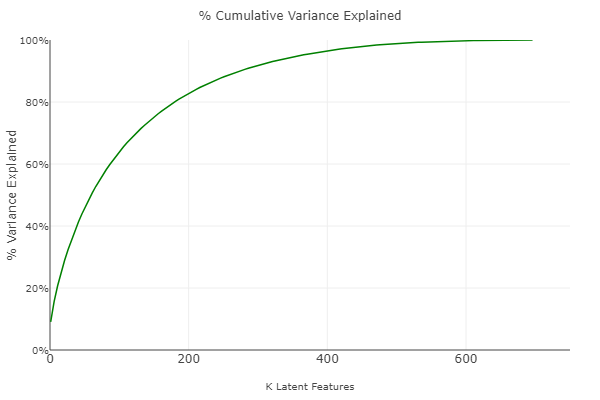

In [93]:

Image(filename="static/cum_variance_viz.png", width="500") 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [57]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

trace = go.Scatter(
        x=num_latent_feats,
        y= 1 - (np.array(sum_errs)/df.shape[0]),            
        mode='linemarkers',
        line=dict(color='Orange', width=1.5),
        name='Training Error'
)

layout = go.Layout(
        width = 600,
        height = 400,
        margin = dict(l=50, r=30, t=40, b=50), 
        title = 'Accuracy vs Number of SVD Latent Features',    
        titlefont = dict(size=12),    
        yaxis = {
                'title': '% Accuracy',
                'titlefont': dict(size=12),
                'tickfont' : dict(size=10),
                'tickformat': '.0%',
                'gridwidth': None,
                'range': [0,1]
        },
        xaxis = {
                'title': 'K Latent Features', 
                'titlefont': dict(size=10),
                'range': [0,750]
        }
    )   

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

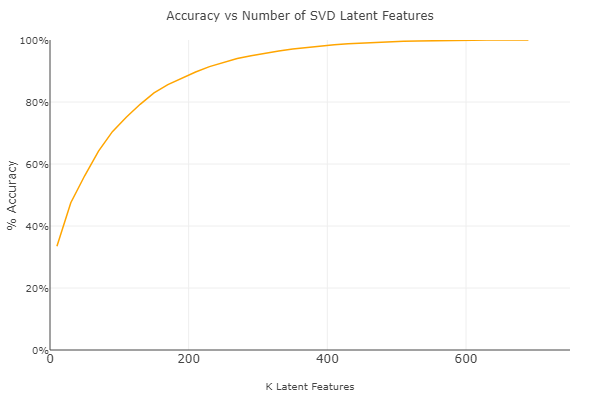

In [94]:
Image(filename="static/accuracy_viz.png", width="500") 


Note: There is a clear correlation between the graph of cumulative explained variance and the percentage accuracy of SVD predictions. As the number of latent factors (k) increases, it leads to a better explanation of the data, which, in turn, translates to higher accuracy in predictions. The two metrics show a parallel improvement trend, highlighting the importance of selecting an optimal number of latent factors to balance model complexity and predictive power.

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [58]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    user_item_train = df_train.groupby(['user_id', 'article_id'])['user_id'].nunique().unstack().fillna(0)
    user_item_test = df_test.groupby(['user_id', 'article_id'])['user_id'].nunique().unstack().fillna(0)

    test_idx = list(df_test.user_id.unique())
    test_arts = list(df_test.article_id.unique())
        
    return user_item_train, user_item_test, test_idx, test_arts


In [59]:
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)
print('Training User-Item:',  user_item_train.shape)
print('Test User-Item:', user_item_test.shape)

Training User-Item: (4487, 714)
Test User-Item: (682, 574)


In [60]:
# total test users
print('Unique Users in Test data:', user_item_test.shape[0])

# articles not present in training dataset - new users
print('Unseen Users in Test data:', len(np.setdiff1d(user_item_test.index, user_item_train.index)))

# unique articles
print('Unique Articles in Test data:', len(test_arts))

# overlaps in training and test datasets
print('Overlaps in Training and Test:', len(np.intersect1d(user_item_test.index, user_item_train.index)))


Unique Users in Test data: 682
Unseen Users in Test data: 662
Unique Articles in Test data: 574
Overlaps in Training and Test: 20


In [61]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?':d 
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  


The following exercise focuses on evaluating a recommendation system that employs Singular Value Decomposition (SVD) on both training and test datasets. SVD is used to create a model capable of predicting user-article interactions. Here's how it operates:

First, the SVD model is constructed using the training dataset. The objective is to uncover underlying patterns in user behavior, with the aim of predicting which articles users are likely to interact with.

Next, the code applies these predictions to both the full training dataset and a subset of the training dataset that exclusively includes users common to both the training and test datasets. These predictions serve as the test predictions and will be compared against a subset of the test dataset containing common users.

Therefore, this code is responsible for identifying these common users and forming two subsets: one for the test dataset and another for the U, S, and V decompositions of the training dataset, all based on the common elements shared between the datasets.

Finally, the code calculates the error by comparing the predictions with the actual user-interactions. This process is iterated for various levels of k latent factors. In this context, k represents the number of latent factors used in the dot product multiplication of U, S, and Vt, but it's important to note that this multiplication is performed for only a subset of k factors.

The purpose of this iteration is to assess how the choice of k influences the accuracy of the predictions. By varying the number of latent factors, the code evaluates the impact on prediction quality and helps determine the optimal value of k for the recommendation system.


In [62]:

# fit SVD on the user_item_train matrix
# fit svd similar to above then use the cells below

def svd_get(user_item):
    """
    Perform Singular Value Decomposition (SVD) on a user-item matrix.

    INPUT:
    user_item - (pandas DataFrame) A user-item matrix with users as rows and items as columns

    OUTPUT:
    u - (numpy array) Left singular vectors of the decomposition
    s - (numpy array) Singular values
    vt - (numpy array) Right singular vectors (transposed)
    """

    u, s, vt = np.linalg.svd(user_item, full_matrices=True)    
    
    return u, s, vt

    
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

# Fit SVD decomposition for Train
u_train, s_train, vt_train =  svd_get(user_item_train)
print('Train U:', u_train.shape, 'Train S:', s_train.shape, 'Train VT:',vt_train.shape,'\n')
#---------------------------------------------------------------------------------------------------

# Identify common users and articles
common_users = user_item_train.index.intersection(test_idx)
common_articles = user_item_train.columns.intersection(test_arts)
print('Common Users:', len(common_users), 'Common Articles:', len(common_articles))
print(common_users, '\n')

# Reshape test set to keep only users that we can make predictions for
# We will then compare the test predictions with this actual test subset
user_item_test_subset = user_item_test.loc[common_users, common_articles]
print('Test Common Subset:', user_item_test_subset.shape)
#---------------------------------------------------------------------------------------------------

# Identify commonn user and column indices in Train
train_row_idx = user_item_train.index.isin(test_idx)
train_col_idx = user_item_train.columns.isin(test_arts)
print('Common User Index:', len(train_row_idx), 'Common Article Index:', len(train_col_idx))
print(train_row_idx, '\n')

# Create u_test to have only users and articles that we can make predictions for
u_test = u_train[train_row_idx, :]
vt_test = vt_train[:, train_col_idx]
print('Train U Subset:', u_test.shape, 'Train VT Subset:', vt_test.shape,'\n')
#---------------------------------------------------------------------------------------------------

num_latent_feats = np.arange(5,710,10)
print('No Latent Features:', len(num_latent_feats))


def svd_kpredict(u, s, vt, k):
    """
    Generate predictions using SVD matrices with a specified number of latent features.

    INPUT:
    u - (numpy array) Left singular vectors of the decomposition
    s - (numpy array) Singular values
    vt - (numpy array) Right singular vectors (transposed)
    k - (int) Number of latent features to use

    OUTPUT:
    svd_predict - (numpy array) Predicted ratings/interactions matrix
    """

    u_new, s_new, vt_new = u[:, :k], np.diag(s[:k]), vt[:k, :]
    svd_predict = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    return svd_predict


def svd_error(user_item, user_item_predict):
    """
    Calculate the sum of absolute errors between the actual and predicted user-item matrices.

    INPUT:
    user_item - (pandas DataFrame/numpy array) Actual user-item matrix
    user_item_predict - (numpy array) Predicted user-item matrix

    OUTPUT:
    svd_error - (float) Total sum of absolute errors
    """

    error = np.subtract(user_item, user_item_predict).sum()
    svd_error = np.sum(np.abs(error))

    return np.sum(svd_error)


def svd_performance(u_train, s_train, vt_train, u_test, vt_test, user_item_train, user_item_subset, num_latent_feats):
    """
    Evaluate the performance of SVD predictions for a range of latent features on both training and test datasets.

    INPUT:
    u_train - (numpy array) U matrix from SVD (training data)
    s_train - (numpy array) Sigma matrix from SVD (training data)
    vt_train - (numpy array) VT matrix from SVD (training data)
    u_test - (numpy array) U matrix for subset of training users
    vt_test - (numpy array) VT matrix for subset of training articles
    user_item_train - (pandas DataFrame) Training user-item matrix
    user_item_subset - (pandas DataFrame) Subset of the user-item matrix for test prediction
    #users_to_predict - (list) List of users to make predictions for
    num_latent_feats - (numpy array) Range of latent feature numbers to evaluate

    OUTPUT:
    k_train_error - (list) List of total prediction errors for each number of latent features (training set)
    k_test_error - (list) List of total prediction errors for each number of latent features (test set)
    """
    
    k_train_error = []
    k_test_error = []

    for k in num_latent_feats: 
        # Make predictions by taking the dot product
        user_item_train_preds = svd_kpredict(u_train, s_train, vt_train, k)
        user_item_test_preds = svd_kpredict(u_test, s_train, vt_test, k)

        # Compute prediction errors
        train_error = svd_error(user_item_train, user_item_train_preds)
        test_error = svd_error(user_item_subset, user_item_test_preds)        

        k_train_error.append(train_error)
        k_test_error.append(test_error)

    return k_train_error, k_test_error


Train U: (4487, 4487) Train S: (714,) Train VT: (714, 714) 

Common Users: 20 Common Articles: 574
Int64Index([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801, 3968,
            3989, 3990, 3998, 4002, 4204, 4231, 4274, 4293, 4487],
           dtype='int64') 

Test Common Subset: (20, 574)
Common User Index: 4487 Common Article Index: 714
[False False False ..., False False  True] 

Train U Subset: (20, 4487) Train VT Subset: (714, 574) 

No Latent Features: 71


In [71]:

# Perform evaluation at different K

k_train_error, k_test_error = svd_performance(u_train, s_train, vt_train, u_test, vt_test, user_item_train, 
    user_item_test_subset, num_latent_feats)
#print('No of errors:', len(k_train_error), len(k_test_error))

# Calculate the % accuracy of predictions
# Note: the denominiator represents total number of interactions 

acc_train = 1 - (np.array(k_train_error) /df_train.shape[0])
acc_test = 1 - (np.array(k_test_error)/ df_test.loc[df_test['user_id'].isin(list(common_users)),:].shape[0])

# Plot the Test and Training accuracy for different K

trace1 = go.Scatter(
        x=num_latent_feats,
        y=acc_train,            
        mode='linemarkers',
        line=dict(color='DarkSlateGrey', width=1.5),
        name='Training Accuracy'
)
trace2 = go.Scatter(
        x=num_latent_feats,
        y=acc_test,            
        mode='linemarkers',
        line=dict(color='Red', width=1.5),
        name='Test Accuracy'
)
layout = go.Layout(
        width = 600,
        height = 400,
        margin = dict(l=50, r=30, t=40, b=50), 
        title = 'Accuracy vs Number of SVD Latent Features',    
        titlefont = dict(size=12),    
        yaxis = {
                'title': '% Accuracy',
                'titlefont': dict(size=12),
                'tickfont' : dict(size=10),
                'tickformat': '.0%',
                'gridwidth': None,
                'range': [0,1]
        },
        xaxis = {
                'title': 'K Latent Features', 
                'titlefont': dict(size=10),
                'range': [0,750]
        },        
        legend = {
                'font': dict(size=10),
                'x': 0.8,  # Horizontally center the legend
                'y': 0.8,  # Adjust vertical position as needed
                'xanchor': 'center',  # Ensure that x=0.5 is the center of the legend
                'yanchor': 'middle'   # Ensure that y=0.5 is the middle of the legend
        }
    )   

fig = go.Figure(data=[trace1, trace2], layout=layout)

iplot(fig)


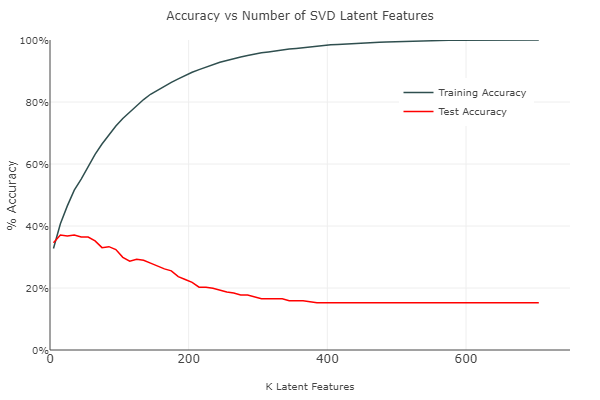

In [96]:
Image(filename="static/train_vs_test_accuracy_viz.png", width="500") 

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

Singular Value Decomposition (SVD) predictions were made using the training dataset, focusing on common users shared between the training and test datasets. These predictions were then evaluated on the test dataset, targeting common users and items present in both datasets.  

Increasing the number of latent features (k) in the training dataset improved prediction accuracy by capturing intricate patterns and closely matching training data interactions up to a certain point. However, when evaluating SVD predictions on the test dataset, accuracy decreased even with larger k values. This decline was attributed to overfitting in the training dataset, where the model became too tailored to training data interactions, limiting its ability to generalize effectively.

To address these challenges, consider:

- Regularization: Use ridge or Lasso regression to prevent overfitting by penalizing noisy patterns in training data.
- Feature Engineering: Create meaningful features or latent factors to enhance model generalization.
- Data Splitting: Reevaluate training-test data splitting to ensure real-world representation.

In general cases, also consider:

- Cross-Validation: Implement techniques like k-fold cross-validation for better generalization and performance estimation.
- Metric Choice: Explore alternative metrics, like standardized view counts or weighted repeated counts, for interaction strength.
- Dimensionality Reduction: Assess how reducing the number of latent features (k) impacts generalization, finding the right balance between underfitting and overfitting.


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [72]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0